# AMAZON MUSICAL INSTRUMENT REVIEWS

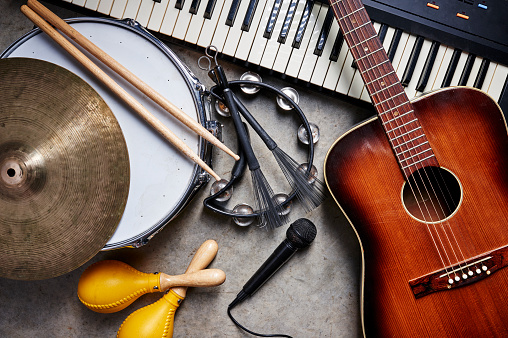!

# Table of Contents:
* [Introduction to Text Classification](#1)
* [Importing the Dataset](#2)
* [Data Preprocessing](#3)
* [Data Visualization](#4)
* [Sentiment Analysis](#5)
* [Data Modeling](#6)
* [Traditional Algorithms for Text Classification](#7)
* [Text Classification using Deep Learning](#8)
* [Conclusion](#9)

<a id="1"></a> <br>
# Introduction to Text Classification

> It is very hard to extract useful information from unstructured data such as texts or speeches.
> Text Classification can be done in two ways: Manual or Automatic:
* Manual text classification is tedious, time consuming and expensive.
* Text classification using Machine Learning can automatically structure all manner of relevant text, from emails, legal documents, social media, chatbots, surveys, and more in a fast and cost-effective way. This allows companies to save time analyzing text data, automate business processes, and make data-driven business decisions.
 
*The Dataset contains reviews of different Musical Instruments on Amazon*
* We will use Data Visualization techniques to analyse the dataset
* Use **Sentiment Analysis** to classify the positive or  negative reviews
* Use different Classifier models and compare  their accuracies

**What is SENTIMENT ANALYSIS?**
**

**Importing the libraries:**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns

#wordcloud
from wordcloud import WordCloud,STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import collections
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers


from sklearn.metrics import confusion_matrix, classification_report

<a id="2"></a> <br>
# Importing the Dataset

In [2]:
#loading dataset
df=pd.read_csv("../input/amazon-music-reviews/Musical_instruments_reviews.csv")

In [3]:
df.head()

In [4]:
df.info()

<a id="3"></a> <br>
# Data Preprocessing
**Data Cleaning**
*  Dropping missing Reviewer Name and Reviewer text values

In [5]:
df.isna().sum()

In [6]:
df.isna().mean()

Only 0.2% of reviewer name missing so we will drop the entire row of them

Only 0.068% of review text missing so we will drop the entire row of them


In [7]:
#drop missing target rows
missing_target_rows=df[df['reviewerName'].isna()].index
#axis=0 since we're dropping rows
df=df.drop(missing_target_rows,axis=0).reset_index(drop=True)

In [8]:
#drop missing target rows
missing_target_rows=df[df['reviewText'].isna()].index
#axis=0 since we're dropping rows
df=df.drop(missing_target_rows,axis=0).reset_index(drop=True)

Let's find the number of unique values for each features

In [9]:
#dictionary that maps column name to the number of unique values in the column
{column: len(df[column].unique()) for column in df.select_dtypes('object').columns}

**We have to categorize review based on Common sentiments used by reviewers**
* combing review_text and summary under a single column common_text

In [10]:
data=pd.DataFrame(df)

# as we are going to change the values of overall to boolean we copied the dataset to another one

In [11]:
df['common_text']=df['reviewText']+ ' '+df['summary']

In [12]:
common_rev=df[['common_text','overall']]

In [13]:
common_rev.head()

<a id="4"></a> <br>
# Data Visualization
* Here we mark 1 as good and 0 as bad reviews i.e. if rating is <=3 then 0 else 1
* Splitting the good and bad reviews
* Generating a Word Cloud

In [14]:
common_rev['overall']=np.where(common_rev['overall']>=3,1,0)


In [15]:
common_rev.head()

*Splitting the good and bad reviews*

In [16]:
good_words = common_rev[common_rev['overall'] == 1].common_text
bad_words  = common_rev[common_rev['overall'] == 0].common_text

**Word Cloud of Good Words**
> **Here we will use Word Cloud which is a data visualization technique used to represent text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.**

In [17]:
comment_words = ''
stopwords = set(STOPWORDS)
 
for val in good_words:
     
    # typecasting each val to string
    val = str(val)
 
    # splitting the value
    tokens = val.split()
     
    # Converting each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plotting the WordCloud image                      
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [18]:
print('Total ratings per rating:','\n',data.overall.value_counts())

#Number of unique instrument ids
print('Number of unique instruments:',len(data.asin.unique()))
print('Number of rows:',data.shape[0]) 

<a id="5"></a> <br>
# Sentiment Analysis
**Feature Selection**
> **We only require 3 columns to work with for Sentiment analysis**
so from the dataset data that we created earlier we will drop all columns, except reviewText, reviewTime, and the overall sentiment 0 or 1


In [19]:
data['reviewText'] = data['reviewText'] + data['summary']
data = data.drop(['summary'], axis = 1)

In [20]:
data.head()

In [21]:
data2=data.drop(columns=['reviewerID','asin', 'reviewerName','overall','helpful','unixReviewTime','common_text'])

In [22]:
data2.head()

In [23]:
add=common_rev["overall"]
data2=data2.join(add)

In [24]:
data2=data2.rename(columns={"overall":"overall_sentiment"})


In [25]:
data2.head()

**Developing the SENTIMENT CLASSIFIER**

In [26]:
data2.reviewText = data2.reviewText.astype('str')
X = data2['reviewText']
y = data2['overall_sentiment']

In [27]:
X.shape

In [28]:
y.shape

<a id="6"></a> <br>
# Data Modeling
> Splitting the dataset so that there is a training set and a test set.

In [29]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2 , random_state = 0)

* Using **CountVectorizer** to develop a vector of all the words in the string. 
* Importing CountVectorizer and fitting both our training, testing data into it.

In [30]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
ctmTr = cv.fit_transform(X_train)
X_test_ctm = cv.transform(X_test)

print('ctmTr:',ctmTr.shape)
print('X_test_ctm:',X_test_ctm.shape)

Also using **TfidfVectorizer** to develop a vector of all the words in the string

In [31]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

tfidf_x_train =tv.fit_transform(X_train)
tfidf_x_test =tv.transform(X_test)

print('tfidf_x_train:',tfidf_x_train.shape)
print('tfidf_x_test:',tfidf_x_test.shape)

<a id="7"></a> <br>
# Traditional Algorithms for Text Classification

> # **Using LOGISTIC REGRESSION**
*Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more independent variables.*

In [32]:
from sklearn.linear_model import LogisticRegression
#lr
lr = LogisticRegression(random_state=0)

#fit
ctm = lr.fit(ctmTr, y_train)
tfidf = lr.fit(tfidf_x_train, y_train)

#predict
ctm_predict= lr.predict(X_test_ctm)
tfidf_predict = lr.predict(tfidf_x_test)

#accuracy
lr_ctm = accuracy_score(y_test, ctm_predict)
lr_tfidf = accuracy_score(y_test,tfidf_predict)

print('lr ctm accuracy:', lr_ctm)
print('lr tfidf accuracy:', lr_tfidf)

Using Logistic Regression we achive **95.6% accuracy** which is quite good!

In [33]:
#random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

#fit
ctm = rf.fit(ctmTr, y_train)
tfidf = rf.fit(tfidf_x_train, y_train)


#predict
ctm_predict= rf.predict(X_test_ctm)
tfidf_predict = rf.predict(tfidf_x_test)

#accuracy
rf_ctm = accuracy_score(y_test, ctm_predict)
rf_tfidf = accuracy_score(y_test,tfidf_predict)

print('Random Forest ctm accuracy:', rf_ctm)
print('Random Forest tfidf accuracy:', rf_tfidf)


Using Random Forest we achive **95.6% accuracy** which is quite good!

> # **Using Support Vector Machine**
*SVM doesn’t need much training data for accurate results however, requires more computational resources than Naive Bayes, but the results are even faster and more accurate. In the SVM algorithm, each data item is plotted as a point in n-dimensional space (where n is a number of features we have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well*

In [34]:
#Linear SVC
ls =  LinearSVC()

#fit
ctm = ls.fit(ctmTr, y_train)
tfidf = ls.fit(tfidf_x_train, y_train)


#predict
ctm_predict= ls.predict(X_test_ctm)
tfidf_predict = ls.predict(tfidf_x_test)

#accuracy
ls_ctm = accuracy_score(y_test, ctm_predict)
ls_tfidf = accuracy_score(y_test,tfidf_predict)

print('Support Vector Classification ctm accuracy:', ls_ctm)
print('Support Vector Classification tfidf accuracy:', ls_tfidf)

Using Random Forest we achive **95.7% accuracy** which is better!


> # **Using Naive Baiyes**
*Naive Bayes is based on Bayes’s Theorem, which helps us compute the conditional probabilities of the occurrence of two events, based on the probabilities of the occurrence of each individual event.*

In [35]:
nb = MultinomialNB()

#fit
ctm = nb.fit(ctmTr, y_train)
tfidf = nb.fit(tfidf_x_train, y_train)


#predict
ctm_predict= nb.predict(X_test_ctm)
tfidf_predict = nb.predict(tfidf_x_test)

#accuracy
nb_ctm = accuracy_score(y_test, ctm_predict)
nb_tfidf = accuracy_score(y_test,tfidf_predict)

print('Naive Baiyes ctm accuracy:', nb_ctm)
print('Naive Baiyes tfidf accuracy:', nb_tfidf)

Using Naive Baiyes we get almost similar result, **95.6% accuracy**

<a id="8"></a> <br>
# Text Classification using Deep Learning
# > Text Convolutional Neural Network
> *In deep learning, a convolutional neural network is a class of artificial neural network. They are based on the shared-weight architecture of the convolution kernels that slide along input features and provide translation equivariant responses known as feature maps*

**Word Embedding**
Word embedding represents the density of the word vector. This embedding can map semantically similar words. It does not consider the text as a human language but maps the structure of sets of words used in the corpus. They aim to map words into a geometric space which is called an embedding space. 

In [36]:
#word embedding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
Xcnn_train = tokenizer.texts_to_sequences(X_train)
Xcnn_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  
print(X_train[1])
print(Xcnn_train[1])

Here we can see that most common words do not have a large index in our embedding space. Still, the extremely uncommon words will get a higher index value which will be word count + 1 because they hold some information. Those whose occurrence is moderate will be given a moderate index value. Finally, 0 value is reserved and won’t be provided to any text

One problem is that in each sequence is the different length of words, and to specify the length of word sequence, we need to provide a maxlen parameter and to solve this, we need to use pad_sequences(), which simply pads the sequence of words with zeros.

In [37]:
maxlen = 100
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :])

**Making the Model using layers**

In [38]:
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(128, 5, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(10, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
textcnnmodel.summary()

**Fitting the model and finding accuracy**

In [39]:
history = textcnnmodel.fit(Xcnn_train, y_train,
                     epochs=10,
                     verbose=False,
                     validation_data=(Xcnn_test, y_test),
                     batch_size=10)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(loss, accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Text Convolutional Neural Network gives 95.89% testing accuracy

<a id="9"></a> <br>
# Conclusion
> Visualizing and comparing the accuracies of the different **Traditional** models for CountVectorizer and tfidfVectorizer
* **We can see the accuracies of all the models are very high and almost similar**
* **However Support Vector Machine using CountVectorizer has the highest accuracy**

In [40]:
data3 = {'Accuracy': [lr_ctm * 100, lr_tfidf * 100, ls_ctm *100, ls_tfidf * 100, nb_ctm * 100, nb_tfidf * 100 ],
                   'model': ['Logistic Regression CV', 'Logistic Regression tfidf', 'Support Vector CV','Support Vector tfidf','Naive Baiyes CV', 'Naive Baiyes tfidf' ]}
df_ = pd.DataFrame(data3, columns = ['Accuracy', 'model'])
df_.head(7)

In [41]:
plt.figure(figsize = (17,7))
sns.lineplot(y = df_.Accuracy, x = df_.model)

In [42]:
data4 = {'Accuracy': [lr_ctm * 100, lr_tfidf * 100, ls_ctm *100, accuracy * 100, ls_tfidf * 100, nb_ctm * 100, nb_tfidf * 100 ],
                   'model': ['Logistic Regression CV', 'Logistic Regression tfidf', 'TextCNN','Support Vector CV','Support Vector tfidf','Naive Baiyes CV', 'Naive Baiyes tfidf' ]}
df1_ = pd.DataFrame(data4, columns = ['Accuracy', 'model'])
df1_.head(7)

In [43]:
plt.figure(figsize = (17,7))
sns.lineplot(y = df1_.Accuracy, x = df1_.model)

* **Comparing the traditional models with the Deep Learning Model we can see TextCNN has more accuracy than most of the traditional algorithms**